In [ ]:
# default_exp httpapi

# HTTP API

> HTTP API based Python functions to interact with IPFS

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import requests
import json
from fastcore.all import *
import pandas as pd

In [ ]:
#export
def get_coreurl(
    local:bool=True, # If local uses local node, else uses Infura.io gateway
):
    'Set the core url for convenience'
    if local:
        return f"http://127.0.0.1:5001/api/v0"
    else: 
        return f"https://ipfs.infura.io:5001/api/v0"

## How to add file to IPFS 

In [ ]:
#export
def add_items(
    coreurl:str, # Core URL to use
    filepath:str, # Path to the file/directory to be added to IPFS
    wrap_with_directory:str='false', # True if path is a directory
    recursive:str='false', # Add directory paths recursively
    chunker:str='size-262144', # Chunking algorithm, size-[bytes], rabin-[min]-[avg]-[max] or buzhash
    pin:str='true', # Pin this object when adding
    hash_:str='sha2-256', # Hash function to use. Implies CIDv1 if not sha2-256
    progress:str='true', # Stream progress data
    silent:str='false', # Write no output
    cid_version:int=0, # CID version
    **kwargs,
):
    "add file/directory to ipfs"

    params = {}
    params['wrap-with-directory'] = wrap_with_directory
    params['chunker'] = chunker
    params['pin'] = pin
    params['hash'] = hash_
    params['progress'] = progress
    params['silent'] = silent
    params['cid-version'] = cid_version
    params.update(kwargs)

    if recursive == 'false':
        files = {
            'file': open(filepath, 'rb'),
        }
        
    else:
        files = {
            str(fn.name) : open(str(fn), 'rb') for fn in Path(filepath).ls()
        }
    
    response = requests.post(f'{coreurl}/add', 
                             params=params, 
                             files=files)
    try:
        print("Added", filepath, "to IPFS - ","Response", response.status_code)
        return response, json.loads(response.text.strip().split('\n')[-1])

    except:
        print(response.status_code)
        return response, ""

This requires a local IPFS Node to be run. Set up your local node using info [here](https://ipfs.io/#install). 

### Using local IPFS Node
Note: Full list of available `params` on `add` function can be found [here](https://docs.ipfs.io/reference/http/api/#api-v0-add)

1. Choose the core url using `get_coreurl`
2. Call the `add` function with the `coreurl` and `path`
3. Check the status of the `response`
4. Status 200 indicates the request has been posted (check what other status codes mean [here](https://docs.ipfs.io/reference/http/api/#http-status-codes))
5. You can check the file on either `ipfs.io` or `infura.io`

In [ ]:
#ignoretest
url = get_coreurl(); url

'http://127.0.0.1:5001/api/v0'

In [ ]:
#ignoretest
response, jsonobject = add_items(url, "../README.md")

Added ../README.md to IPFS -  Response 200


You can view the added file on [ipfs.io](https://ipfs.io/ipfs/QmfQ5hFqZ2DFUwTfnaPEuVXXSXsq552AXMvjrQtbkQKWLZ)

To view any CID on ipfs.io `https://ipfs.io/ipfs/CID`

In [ ]:
#ignoretest
jsonobject

{'Name': 'README.md',
 'Hash': 'QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B',
 'Size': '1190'}

### Using infura.io gateway

This works without a local IPFS node running

In [ ]:
#ignoretest
url = get_coreurl(local=False); url

'https://ipfs.infura.io:5001/api/v0'

In [ ]:
#ignoretest
response, jsonobject = add_items(url, "../README.md")

Added ../README.md to IPFS -  Response 200


In [ ]:
#ignoretest
jsonobject

{'Name': 'README.md',
 'Hash': 'QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B',
 'Size': '1190'}

You can view the added file on [infura.io](https://ipfs.infura.io/ipfs/QmfQ5hFqZ2DFUwTfnaPEuVXXSXsq552AXMvjrQtbkQKWLZ)

To view any CID on infura `https://ipfs.infura.io/ipfs/CID`

## How to add a directory to IPFS

To add a directory, simply pass a directory as the `filepath` and set `wrap_with_directory` and `recursive` flag as `true`

In [ ]:
#ignoretest
#hide
url = get_coreurl(); url

'http://127.0.0.1:5001/api/v0'

In [ ]:
#ignoretest
response, jsonobject = add_items(url, "../test", wrap_with_directory='true', recursive='true')

Added ../test to IPFS -  Response 200


In [ ]:
#ignoretest
[json.loads(each) for each in response.text.split('\n')[:-1][-3:]]

[{'Name': 'test.txt', 'Bytes': 24},
 {'Name': 'test.txt',
  'Hash': 'QmTT8vwdbnP9Ls8bSY1LMyW4a8bEwTYZa5izEoJMBtTPfb',
  'Size': '32'},
 {'Name': '',
  'Hash': 'QmbE8H8GsHVm7Nd8vrkxdZiDdLersvvYy4ZheFAmqSRSTC',
  'Size': '27608396'}]

The added directory can be found using the last [Hash](https://bafybeidzhahbmc4kxtfgc4245o6vqwefkbiw5flkyeycogbtgz54kpv7zu.ipfs.infura-ipfs.io/)

Your directory on ipfs.io will look like below. 

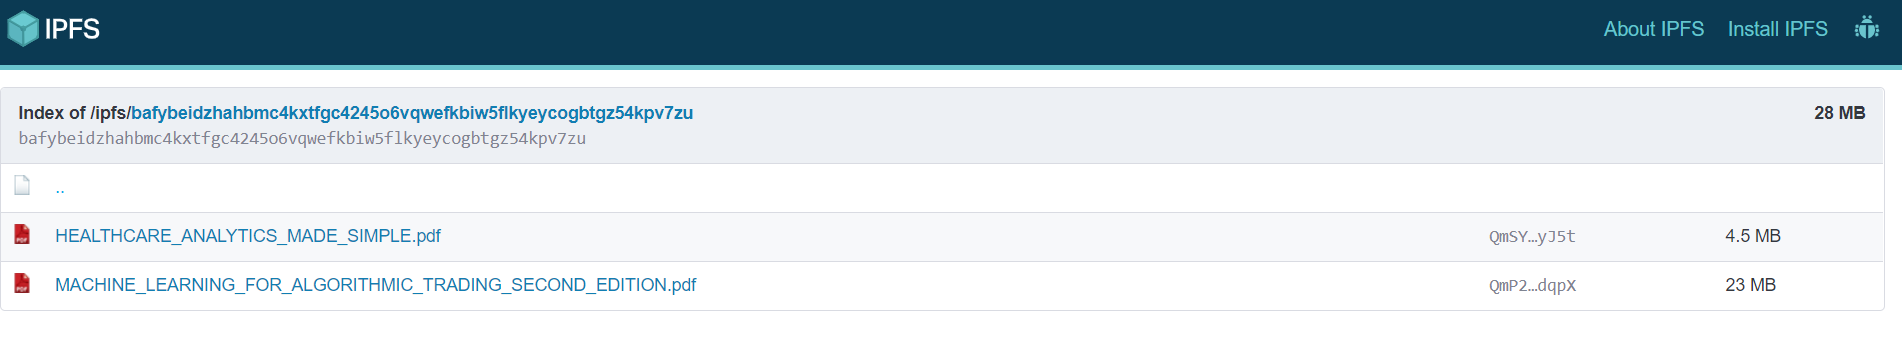

## How to get a file from IPFS

In [ ]:
#export

# doesnt save the file in the output folder given
def get_items(
    coreurl:str,
    cid:str, # The path to the IPFS object(s) to be outputted
    output:str='', # The path where the output should be stored
    **kwargs
):
    'Download IPFS objects'

    params = {}
    params['arg'] = cid
    params['output'] = output
    params.update(kwargs)

    response = requests.post(f'{coreurl}/get', params=params)

    return response


def cat(
    coreurl:str, 
    cid:str, # The path to the IPFS object(s) to be outputted
    offset:int, # Byte offset to begin reading from
    length:int, # Maximum number of bytes to read
    **kwargs
):
    'Show IPFS object data'
    
    params = {}
    params['args'] = cid
    params['offset'] = offset
    params['length'] = length
    params.update(kwargs)
    
    return requests.post(f'{coreurl}/cat', params=params)

In [ ]:
#ignoretest
response = get_items(url, cid='QmXPhkw5QTpP4eqNVfAudVDj8waZYTBb4bToHApvRWwXB5')

In [ ]:
#ignoretest
response.content.decode("utf-8")[500:700]

'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00# Welcome to Immerse by Algovera\r\n> A python library by Algovera to interact with IPFS and IPFS ecosystem such as the common pinning services\r\n\r\n\r\n## What is Immerse?\r\n\r\nImmerse is a pytho'

## Get Peers

In [ ]:
#export
def get_peers(
    coreurl, 
    verbose='true', # Display all extra information
    streams='false', # Also list information about open streams for each peer
    latency='false', # Also list information about latency to each peer
    direction='false' # Also list information about the direction of connection
):
    'List peers with open connections.'
    
    params = {}
    params['verbose'] = verbose
    params['streams'] = streams
    params['latency'] = latency
    params['direction'] = direction

    return requests.post(f"{coreurl}/swarm/peers", params=params).json()

### Getting peers

In [ ]:
#ignoretest
#hide
url = get_coreurl(local=True)

In [ ]:
#ignoretest
response = get_peers(url)

In [ ]:
#ignoretest
response['Peers'][0]

{'Addr': '/ip4/1.237.18.217/udp/4001/quic',
 'Peer': '12D3KooWKKETz8eDfu1oQHDvet9qCErV45PXZEQjnQa9xR8GjjaC',
 'Latency': '238.007942ms',
 'Muxer': '',
 'Direction': 2,
 'Streams': [{'Protocol': '/ipfs/kad/1.0.0'}]}

## Get response from DHT

In [ ]:
#export
def find_dht_peer(
    coreurl:str,
    key:str,  # The ID of the peer to search for
    verbose:str='true', #Print extra information
):
    'Find the multiaddresses associated with a Peer ID.'
    
    params = {}
    params['arg'] = key
    params['verbose'] = verbose

    return requests.post(f'{coreurl}/dht/findpeer', params=params).json()

def find_value_provider(
    coreurl:str,
    key:str,  # The key to find providers for
    verbose:str='true', #Print extra information
):
    'Find peers that can provide a specific value, given a key.'
    
    params = {}
    params['arg'] = key
    params['verbose'] = verbose

    return requests.post(f'{coreurl}/dht/findpeer', params=params)

def get_dht_value(
    coreurl:str,
    key:str,  # The key to find a value for
    verbose:str='true', #Print extra information
):
    'Given a key, query the routing system for its best value.'
    
    params = {}
    params['arg'] = key
    params['verbose'] = verbose

    return requests.post(f'{coreurl}/dht/get', params=params).json()

In [ ]:
#hide
url = get_coreurl()

### Find peers

In [ ]:
#ignoretest
response = find_dht_peer(url, 'QmaCpDMGvV2BGHeYERUEnRQAwe3N8SzbUtfsmvsqQLuvuJ')

In [ ]:
#ignoretest
response

{'Extra': '',
 'ID': '',
 'Responses': [{'ID': 'QmaCpDMGvV2BGHeYERUEnRQAwe3N8SzbUtfsmvsqQLuvuJ',
   'Addrs': ['/ip4/104.131.131.82/tcp/4001',
    '/ip4/104.131.131.82/udp/4001/quic',
    '/ip4/127.0.0.1/udp/4001/quic',
    '/ip4/127.0.0.1/tcp/4001']}],
 'Type': 2}

### Find peers who can provide a value

Let's see who can provide this [image](https://ipfs.io/ipfs/Qme7ss3ARVgxv6rXqVPiikMJ8u2NLgmgszg13pYrDKEoiu)

In [ ]:
#ignoretest
response = find_value_provider(url, 'Qme7ss3ARVgxv6rXqVPiikMJ8u2NLgmgszg13pYrDKEoiu')

In [ ]:
#ignoretest
df_response = pd.DataFrame([json.loads(each) for each in response.text.split('\n')[:-1]])

In [ ]:
#ignoretest
df_response.head()


,Extra,ID,Responses,Type
0,,12D3KooWCcFF1uGDMsxw71KEuum3PV3mP2YqJ9YBxpMLCq...,None,0
1,,12D3KooWGgo5kFeFKczz5C4tzZn6bgsjEoaXnWSjZVvvFA...,None,0
2,,12D3KooWL2NZPgWazFkSCaz66FpEA2ELsEpweY83yKYEB1...,None,0
3,,12D3KooWCx3mdN7WypCLXo86F72SmEtxnSaJ4K5F3XGw5G...,None,7
4,,12D3KooWRbLQD3w8bUAXtrdrBaCFFk3ZywBMoRdJrMeHLs...,None,0


### Get a value from a peer

In [ ]:
#ignoretest
response = get_dht_value(url, 'Qme7ss3ARVgxv6rXqVPiikMJ8u2NLgmgszg13pYrDKEoiu') # What sort of key does it take?

In [ ]:
#ignoretest
response

{'Message': 'invalid key', 'Code': 0, 'Type': 'error'}

## Block

In [ ]:
#export 
def block_get(
    coreurl,
    arg:str, # The base58 multihash of an existing block to get

):
    'Get a raw IPFS block.'
    
    params = {}
    params['arg'] = arg

    return requests.post(f'{coreurl}/block/get', params=params)


def block_put(
    coreurl,
    filepath:str, # Path to file
    mhtype:str='sha2-256', # multihash hash function.
    mhlen:int=-1, # Multihash hash length
    pin:str='false', #  pin added blocks recursively
    **kwargs,
):
    'Store input as an IPFS block.'
    
    params = {}
    params['mhtype'] = mhtype
    params['mhlen'] = mhlen
    params['pin'] = pin
    params.update(kwargs)
    
    return requests.post(f'{coreurl}/block/put', params=params, files={'files':open(filepath, 'rb')})


def block_rm(
    coreurl,
    arg:str, # Bash58 encoded multihash of block(s) to remove
    force:str='false', # Ignore nonexistent blocks.
    quiet:str='false', # Write minimal output.
):
    'Remove IPFS block(s).'
    
    params = {}
    params['arg'] = arg
    params['force'] = force
    params['quiet'] = quiet
    
    return requests.post(f'{coreurl}/block/rm', params=params)


def block_stat(
    coreurl,
    arg:str, # Bash58 encoded multihash of block(s) to remove

):
    'Print information of a raw IPFS block.'
    
    params = {}
    params['arg'] = arg
    
    return requests.post(f'{coreurl}/block/stat', params=params)

### Build a block 

In [ ]:
#ignoretest
response = block_put(url, '../README.md')

In [ ]:
#ignoretest
response.text

'{"Key":"QmSmcEgnU4B8LGrf1LN8DBjndNmptDgabh2L5vvM5nsYsZ","Size":1179}\n'

### Get stat on a block

In [ ]:
#ignoretest
response = block_stat(url, 'QmSmcEgnU4B8LGrf1LN8DBjndNmptDgabh2L5vvM5nsYsZ')

In [ ]:
#ignoretest
response.text

'{"Key":"QmSmcEgnU4B8LGrf1LN8DBjndNmptDgabh2L5vvM5nsYsZ","Size":1179}\n'

### Get a block

In [ ]:
#ignoretest
response = block_get(url, 'QmSmcEgnU4B8LGrf1LN8DBjndNmptDgabh2L5vvM5nsYsZ')

In [ ]:
#ignoretest
response.text

'# Welcome to Immerse by Algovera\r\n> A python library by Algovera to interact with IPFS and IPFS ecosystem such as the common pinning services\r\n\r\n\r\n## What is Immerse?\r\n\r\nImmerse is a python library by Algovera to interact with IPFS and IPFS ecosystem such as the common pinning services. It is designed by data scientists for data scientists to interact with the IPFS ecosystem without leaving the comfort of python and jupyter notebook.\r\n\r\nYou can learn more about IPFS [here](https://ipfs.io/#why)\r\n\r\nIPFS is built using the go-lang and javascript. With Immerse, you can interact with IPFS using the exposed [HTTP RPC API](https://docs.ipfs.io/reference/http/api/#getting-started). \r\n\r\nYou will need a local IPFS Node running to use the HTTP API (even when using Immerse). As an alternative, you can connect via the [Infura](https://infura.io/product/ipfs)\'s dedicated IPFS gateway. Immerse provide both ways to interact with IPFS.\r\n\r\n## Installing\r\n\r\nto do: instr

### Remove a block

In [ ]:
#ignoretest
response = block_rm(url, 'QmSmcEgnU4B8LGrf1LN8DBjndNmptDgabh2L5vvM5nsYsZ')

In [ ]:
#ignoretest
response.text

'{"Hash":"QmSmcEgnU4B8LGrf1LN8DBjndNmptDgabh2L5vvM5nsYsZ"}\n'

## Mutable File Sysyem (files)

## IPNS

In [ ]:
#|hide
from nbdev.export import *
notebook2script()

Converted 00_httpapi.ipynb.
Converted index.ipynb.
